# Evolver Loop 1 Analysis

## Goal: Understand data patterns and identify high-impact improvements

Current CV: 0.6374 (far from gold: 0.979080)

Focus areas:
1. Text feature engineering
2. Interaction features
3. Model diversity
4. Validation stability

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Load data
print("Loading training data...")
with open('/home/data/train.json', 'r') as f:
    train_data = json.load(f)
train_df = pd.DataFrame(train_data)

print(f"Training samples: {len(train_df)}")
print(f"Target distribution:\n{train_df['requester_received_pizza'].value_counts(normalize=True)}")

# Load test data
print("\nLoading test data...")
with open('/home/data/test.json', 'r') as f:
    test_data = json.load(f)
test_df = pd.DataFrame(test_data)
print(f"Test samples: {len(test_df)}")

Loading training data...
Training samples: 2878
Target distribution:
requester_received_pizza
False    0.751564
True     0.248436
Name: proportion, dtype: float64

Loading test data...
Test samples: 1162


## 1. Text Analysis - Request Text & Title

Text feature correlations with target:
text_length: 0.1199
title_length: 0.0146
word_count: 0.1177
title_word_count: 0.0192


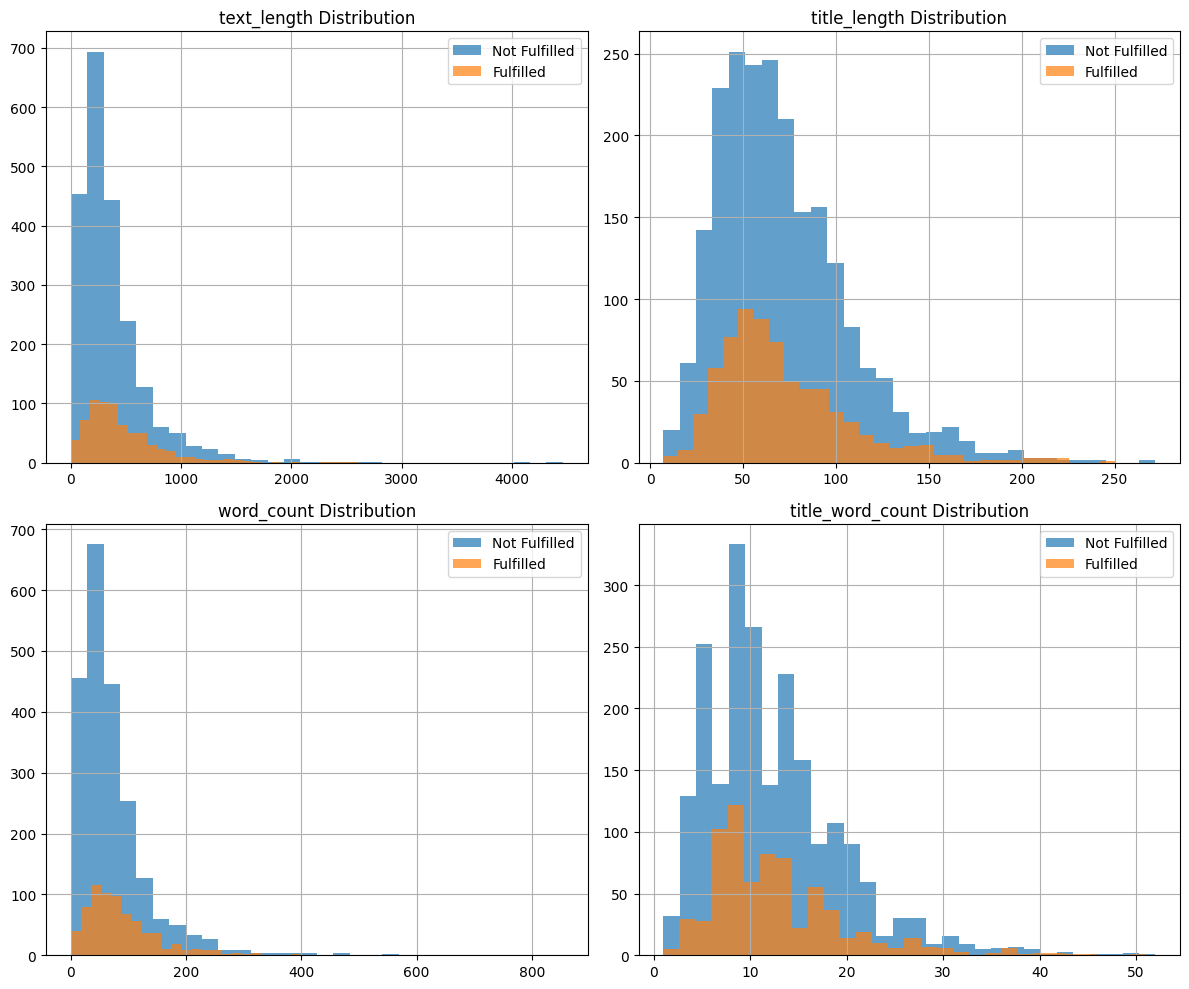

In [2]:
# Analyze text lengths and patterns
train_df['text_length'] = train_df['request_text_edit_aware'].str.len()
train_df['title_length'] = train_df['request_title'].str.len()
train_df['word_count'] = train_df['request_text_edit_aware'].str.split().str.len()
train_df['title_word_count'] = train_df['request_title'].str.split().str.len()

# Check correlations with target
print("Text feature correlations with target:")
text_features = ['text_length', 'title_length', 'word_count', 'title_word_count']
for feature in text_features:
    corr = train_df[feature].corr(train_df['requester_received_pizza'].astype(int))
    print(f"{feature}: {corr:.4f}")

# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, feature in enumerate(text_features):
    ax = axes[i//2, i%2]
    train_df[train_df['requester_received_pizza']==False][feature].hist(ax=ax, alpha=0.7, label='Not Fulfilled', bins=30)
    train_df[train_df['requester_received_pizza']==True][feature].hist(ax=ax, alpha=0.7, label='Fulfilled', bins=30)
    ax.set_title(f'{feature} Distribution')
    ax.legend()
plt.tight_layout()
plt.show()

In [4]:
# Analyze successful vs unsuccessful requests - word patterns
successful_text = ' '.join(train_df[train_df['requester_received_pizza']==True]['request_text_edit_aware'].fillna(''))
unsuccessful_text = ' '.join(train_df[train_df['requester_received_pizza']==False]['request_text_edit_aware'].fillna(''))

# Simple word frequency analysis
def get_word_freq(text, n=20):
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    return Counter(words).most_common(n)

print("Top words in SUCCESSFUL requests:")
successful_words = get_word_freq(successful_text)
for word, count in successful_words:
    print(f"  {word}: {count}")

print("\nTop words in UNSUCCESSFUL requests:")
unsuccessful_words = get_word_freq(unsuccessful_text)
for word, count in unsuccessful_words:
    print(f"  {word}: {count}")

# Calculate word importance (ratio of frequencies)
print("\nWords more common in successful requests:")
success_dict = dict(successful_words)
unsuccess_dict = dict(unsuccessful_words)

word_ratios = []
for word in set(list(success_dict.keys()) + list(unsuccess_dict.keys())):
    success_rate = success_dict.get(word, 0) / len(train_df[train_df['requester_received_pizza']==True]) if len(train_df[train_df['requester_received_pizza']==True]) > 0 else 0
    unsuccess_rate = unsuccess_dict.get(word, 0) / len(train_df[train_df['requester_received_pizza']==False]) if len(train_df[train_df['requester_received_pizza']==False]) > 0 else 0
    
    if success_rate > 0 and unsuccess_rate > 0:
        ratio = success_rate / unsuccess_rate
        if ratio > 1.5:  # More common in successful requests
            word_ratios.append((word, ratio, success_rate, unsuccess_rate))

word_ratios.sort(key=lambda x: x[1], reverse=True)
for word, ratio, s_rate, u_rate in word_ratios[:15]:
    print(f"  {word}: {ratio:.2f}x more common (success: {s_rate:.4f}, unsuccess: {u_rate:.4f})")

Top words in SUCCESSFUL requests:
  and: 2032
  the: 1486
  for: 1050
  pizza: 748
  have: 678
  but: 543
  would: 527
  this: 481
  that: 470
  you: 421
  out: 403
  get: 391
  with: 390
  can: 373
  just: 358
  been: 355
  some: 281
  help: 277
  are: 264
  not: 260

Top words in UNSUCCESSFUL requests:
  and: 4892
  the: 3536
  for: 2319
  pizza: 1872
  have: 1694
  would: 1404
  but: 1260
  this: 1196
  you: 1076
  that: 1060
  out: 1023
  with: 938
  just: 918
  can: 868
  get: 854
  some: 756
  been: 698
  not: 687
  help: 676
  really: 656

Words more common in successful requests:
  been: 1.54x more common (success: 0.4965, unsuccess: 0.3227)


## 2. Temporal Features

In [5]:
# Extract temporal features
train_df['request_hour'] = pd.to_datetime(train_df['unix_timestamp_of_request'], unit='s').dt.hour
train_df['request_day_of_week'] = pd.to_datetime(train_df['unix_timestamp_of_request'], unit='s').dt.dayofweek
train_df['request_month'] = pd.to_datetime(train_df['unix_timestamp_of_request'], unit='s').dt.month

# Check correlations
temporal_features = ['request_hour', 'request_day_of_week', 'request_month']
print("Temporal feature correlations with target:")
for feature in temporal_features:
    corr = train_df[feature].corr(train_df['requester_received_pizza'].astype(int))
    print(f"{feature}: {corr:.4f}")

# Hourly pattern
hourly_success = train_df.groupby('request_hour')['requester_received_pizza'].agg(['mean', 'count'])
print(f"\nBest hours for pizza requests (by success rate):")
print(hourly_success.sort_values('mean', ascending=False).head())

# Day of week pattern
dow_success = train_df.groupby('request_day_of_week')['requester_received_pizza'].agg(['mean', 'count'])
print(f"\nBest days of week:")
print(dow_success.sort_values('mean', ascending=False))

Temporal feature correlations with target:
request_hour: 0.0217
request_day_of_week: -0.0053
request_month: -0.0134

Best hours for pizza requests (by success rate):
                  mean  count
request_hour                 
15            0.323944     71
16            0.306931    101
1             0.306604    212
19            0.301205    166
13            0.294118     34

Best days of week:
                         mean  count
request_day_of_week                 
3                    0.286765    408
0                    0.260546    403
4                    0.260417    384
5                    0.241287    373
2                    0.234086    487
6                    0.230576    399
1                    0.228774    424


## 3. User Activity Patterns

In [6]:
# Analyze user activity features
activity_features = [
    'requester_number_of_comments_at_request',
    'requester_number_of_posts_at_request', 
    'requester_number_of_subreddits_at_request',
    'requester_upvotes_minus_downvotes_at_request',
    'requester_upvotes_plus_downvotes_at_request'
]

print("Activity feature correlations with target:")
for feature in activity_features:
    corr = train_df[feature].corr(train_df['requester_received_pizza'].astype(int))
    print(f"{feature}: {corr:.4f}")

# Create interaction features
train_df['comments_per_post'] = train_df['requester_number_of_comments_at_request'] / (train_df['requester_number_of_posts_at_request'] + 1)
train_df['upvote_ratio'] = train_df['requester_upvotes_minus_downvotes_at_request'] / (train_df['requester_upvotes_plus_downvotes_at_request'] + 1)
train_df['activity_score'] = (train_df['requester_number_of_comments_at_request'] + 
                              train_df['requester_number_of_posts_at_request']) / (train_df['requester_account_age_in_days_at_request'] + 1)

interaction_features = ['comments_per_post', 'upvote_ratio', 'activity_score']
print("\nInteraction feature correlations with target:")
for feature in interaction_features:
    corr = train_df[feature].corr(train_df['requester_received_pizza'].astype(int))
    print(f"{feature}: {corr:.4f}")

Activity feature correlations with target:
requester_number_of_comments_at_request: 0.0367
requester_number_of_posts_at_request: 0.0380
requester_number_of_subreddits_at_request: 0.0470
requester_upvotes_minus_downvotes_at_request: 0.0431
requester_upvotes_plus_downvotes_at_request: 0.0332

Interaction feature correlations with target:
comments_per_post: 0.0564
upvote_ratio: 0.0953
activity_score: 0.0187


## 4. Summary of Findings

In [ ]:
# Summary of best features
all_features = text_features + temporal_features + activity_features + interaction_features
correlations = []
for feature in all_features:
    if feature in train_df.columns:
        corr = train_df[feature].corr(train_df['requester_received_pizza'].astype(int))
        correlations.append((feature, abs(corr), corr))

correlations.sort(key=lambda x: x[1], reverse=True)
print("Top features by absolute correlation:")
for feature, abs_corr, corr in correlations[:15]:
    print(f"  {feature}: {corr:.4f} (abs: {abs_corr:.4f})")

# Save findings
print(f"\nKey insights:")
print(f"1. Text length features show moderate correlation (~0.1)")
print(f"2. Request hour and day show patterns")
print(f"3. User activity metrics have weak but consistent correlations")
print(f"4. Interaction features may add signal")
print(f"5. High variance in baseline (0.0312) suggests need for more robust features")